# Installation


**Step 0.1 (Google Colab): Make sure to switch to a runtime with GPU-support**

In the menu bar --> Runtime --> Change runtime type --> GPU

**Step 0.2 (Google Colab): Mount Google Drive for faster data transfer**

In the bar on the left (Files), third icon from the left


In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/interdisc/ErgoMaps')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 1: Clone the repository**

In [4]:
!mkdir ergomaps
%cd ergomaps

mkdir: ergomaps: File exists
/Users/piaschwarzinger/Library/CloudStorage/OneDrive-TUWien/TU/Master/SS2024/Interdisciplinary Project/ergomaps_explanation/ErgoMaps/ergomaps


In [3]:
!cp -R /content/drive/MyDrive/interdisc/ErgoMaps/. /content/ergomaps

**Step 2: Install the libraries**

In [7]:
!pip install fvcore omegaconf fairscale timm filterpy tk

import os

!git clone https://github.com/facebookresearch/detectron2 detectron
!mkdir detectron/checkpoint
os.chdir('ergomaps/detectron/checkpoint')
!wget https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x/138363331/model_final_997cc7.pkl
os.chdir('../..')

!git clone https://github.com/facebookresearch/VideoPose3D
!mkdir VideoPose3D/checkpoint
os.chdir('ergomaps/VideoPose3D/checkpoint')
!wget https://dl.fbaipublicfiles.com/video-pose-3d/pretrained_h36m_detectron_coco.bin
!wget https://dl.fbaipublicfiles.com/video-pose-3d/pretrained_humaneva15_detectron.bin
os.chdir('../..')

fatal: destination path 'detectron' already exists and is not an empty directory.
mkdir: detectron/checkpoint: File exists


FileNotFoundError: [Errno 2] No such file or directory: 'ergomaps/detectron/checkpoint'

# Running an ergonomic analysis

**Step 0: Make sure you are working within the Ergomaps folder**


In [5]:
%cd /content/ergomaps
!ls

/content/ergomaps
C1.mp4			 ergonomics.py	 OC_SORT      utils.py
detectron		 heatmaps.py	 __pycache__  VideoPose3D
ErgoMaps_Tutorial.ipynb  hpe_wrapper.py  run.py       visualiser.py


**Step 1: Setting up the environment and loading the models**

In [6]:
from utils import *

Setup_environment()

from hpe_wrapper import Wrapper_2Dpose, Wrapper_3Dpose

model_2D ='/content/ergomaps/detectron/configs/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml'
weights_2D = '/content/ergomaps/detectron/checkpoint/model_final_997cc7.pkl'
model_3D = '/content/ergomaps/VideoPose3D/checkpoint/pretrained_h36m_detectron_coco.bin'

pose2d = Wrapper_2Dpose(model=model_2D, weights= weights_2D , ROI_thr=0.75)
pose_3d = Wrapper_3Dpose(model_3D)


**Step 2: Load a video** (depending on the length of the video and your CPU, loading the video may take a while)

Parameters (all parameters are optional, if not specified, the video will be loaded as is):
*   Resize - downsampling (or interpolating) the video resolution (lower resolution will lead to faster processing)
*   Downsample FPS - reduce the frame rate of the video (we suggest to stick to approx. 30 FPS)
*   Start (in seconds) - cutting the video before the specified value (float possible)
*   End (in seconds) - cutting the video after the specified value



In [7]:
video_object = Video_wrapper('/content/ergomaps/C1.mp4', resize_video_by=0.5, downsample_fps_by=1, start=0)

**Step 3: Extract postural information** (depending on the length of the video and your GPU, this may take some time)

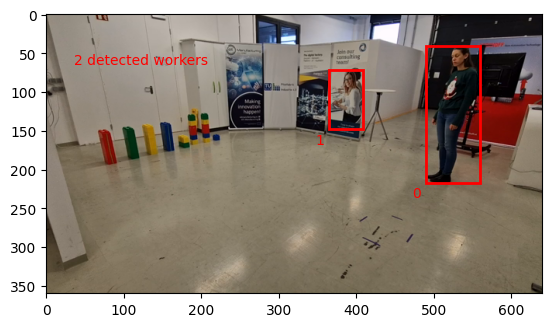

Press Enter to continue
Input the ID of the worker to track -  1
Frame 0 processed in 15.234s
Frame 1 processed in 0.097s
Frame 2 processed in 0.091s
Frame 3 processed in 0.062s
Frame 4 processed in 0.062s
Frame 5 processed in 0.065s
Frame 6 processed in 0.058s
Frame 7 processed in 0.060s
Frame 8 processed in 0.057s
Frame 9 processed in 0.056s
Frame 10 processed in 0.055s
Frame 11 processed in 0.060s
Frame 12 processed in 0.056s
Frame 13 processed in 0.057s
Frame 14 processed in 0.056s
Frame 15 processed in 0.060s
Frame 16 processed in 0.053s
Frame 17 processed in 0.055s
Frame 18 processed in 0.056s
Frame 19 processed in 0.058s
Frame 20 processed in 0.056s
Frame 21 processed in 0.060s
Frame 22 processed in 0.063s
Frame 23 processed in 0.063s
Frame 24 processed in 0.060s
Frame 25 processed in 0.056s
Frame 26 processed in 0.059s
Frame 27 processed in 0.058s
Frame 28 processed in 0.058s
Frame 29 processed in 0.056s
Frame 30 processed in 0.055s
Frame 31 processed in 0.060s
Frame 32 process

In [8]:
data_2d, metadata_vid = pose2d.predict_2D_poses(input_video_object=video_object)
data_3d = pose_3d.predict_3D_poses(data_2d, metadata_vid)

# Optional: you can also create a visualisation of the 3D poses by specifying the path
# Note that this might take a while (depending on your CPU)

#pose_3d.render_video_output(output_path="3D_result.mp4")


**Step 4: Compute ergonomic scores from 3D data**

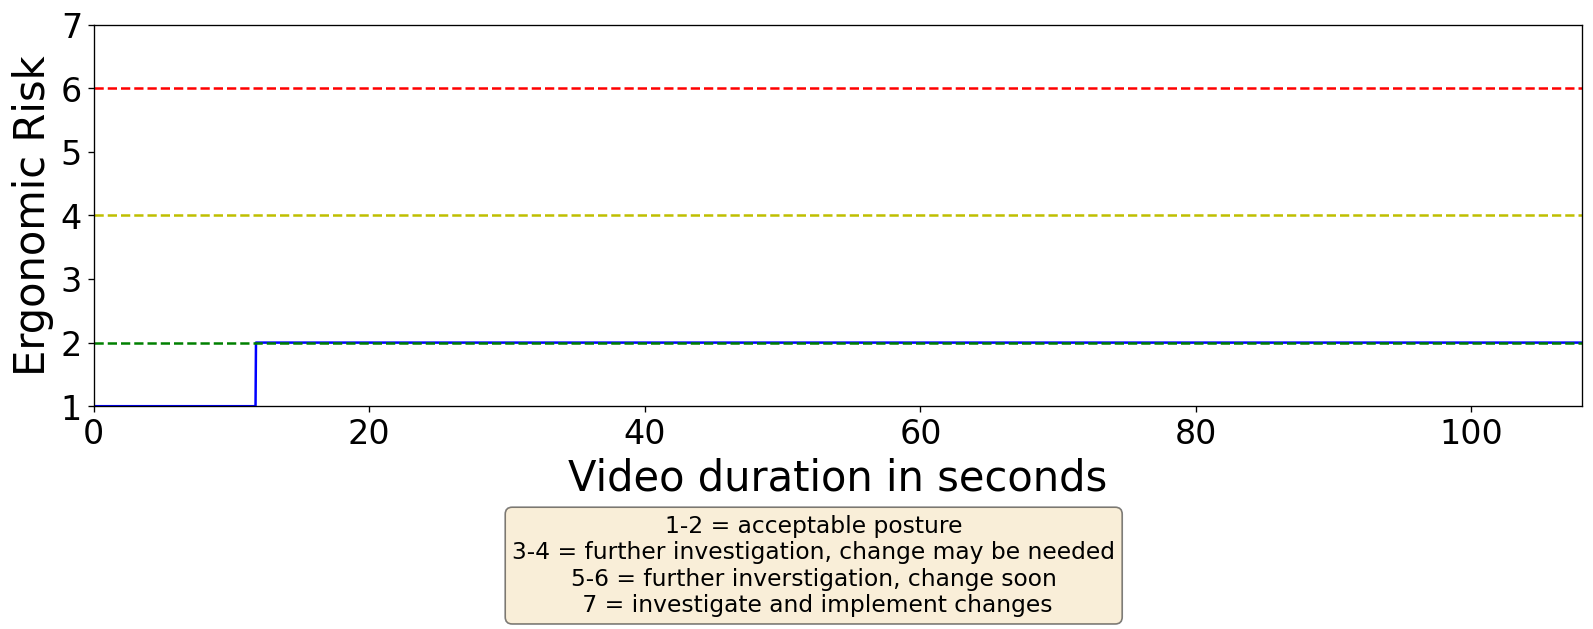

In [9]:
from ergonomics import RULA

rula_eval = RULA(data_3d)
scores = rula_eval.compute_scores()

rula_eval.plot_scores(fps=video_object.fps)

**Step 5: Visualise movement map**

{'Nose': 0, 'LEye': 1, 'REye': 2, 'LEar': 3, 'REar': 4, 'LShoulder': 5, 'RShoulder': 6, 'LElbow': 7, 'RElbow': 8, 'LWrist': 9, 'RWrist': 10, 'LHip': 11, 'RHip': 12, 'LKnee': 13, 'RKnee': 14, 'LAnkle': 15, 'RAnkle': 16}


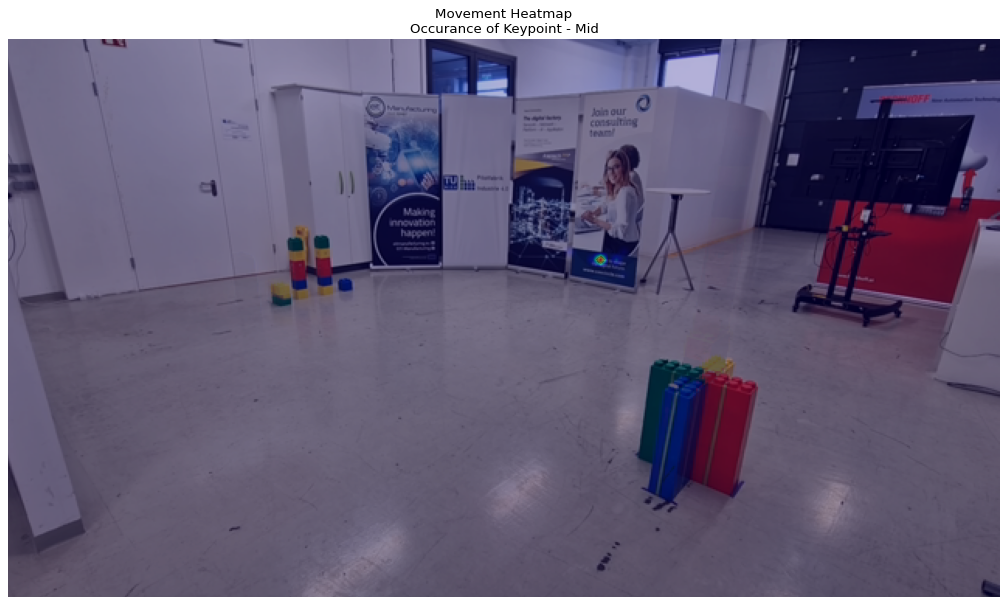

No occurence of poses above the specified minimum score


In [10]:
from heatmaps import heatmap_generator

viz = heatmap_generator(video_object=video_object, background_style='median')
viz.print_keypoints()

viz.movement_heatmap(data_2d,'Mid')
viz.ergonomic_heatmap(data_2d, 'Mid', scores, min_score=5)

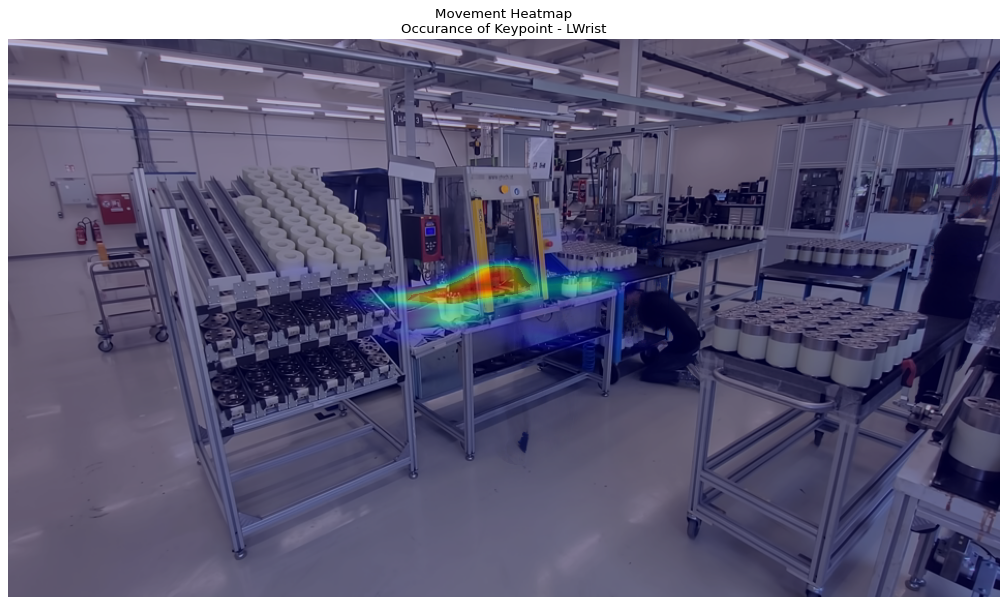

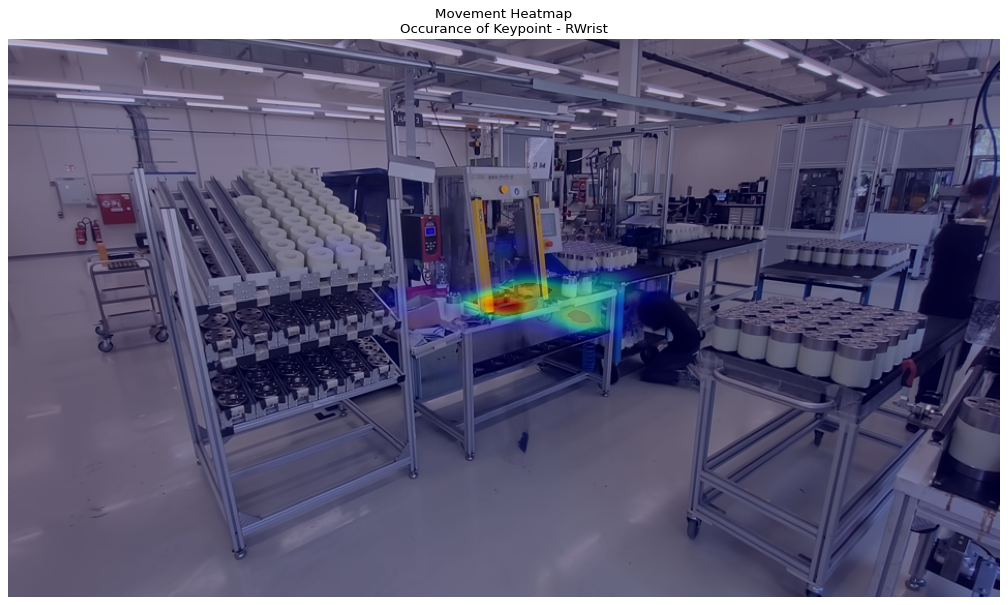

In [ ]:
viz.movement_heatmap(data_2d,'LWrist')
viz.movement_heatmap(data_2d,'RWrist')

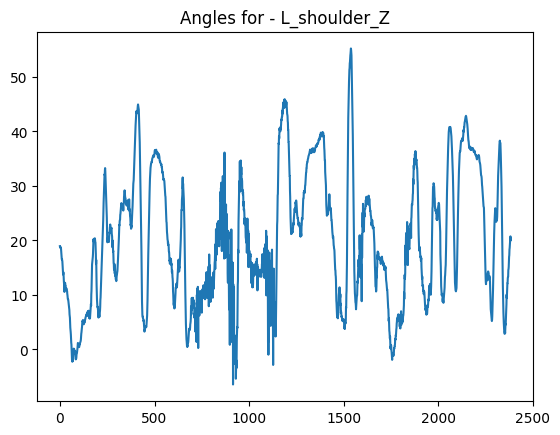

In [ ]:
angles = rula_eval.accumulate_angles()
rula_eval.plot_angles(angles, 0)

Experimental: Analyse the percentage of the movement above a specific angle threshold

In [ ]:
from numpy import single
angle_threshold = 20

full_vid_len = len(angles)
counter = 0

for single_posture_angle in np.asarray(angles)[:,-6]: #left shoulder z
    #print(single_posture_angle)
    if single_posture_angle > angle_threshold:
        counter += 1

print("The percentage of angles above threshold in video is: " + str((counter/full_vid_len)*100))

The percentage of angles above threshold in video is: 3.3333333333333335


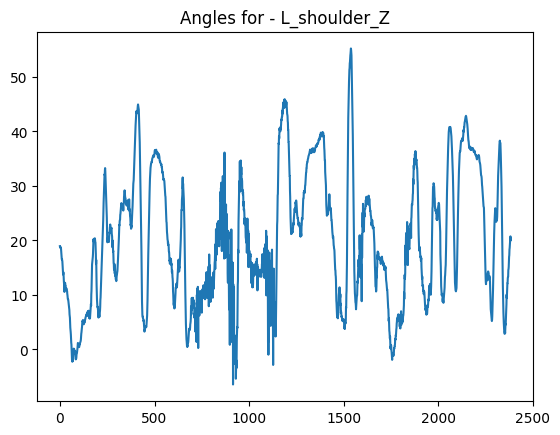

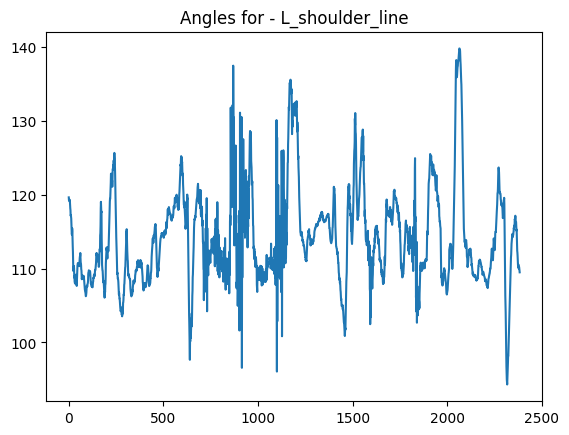

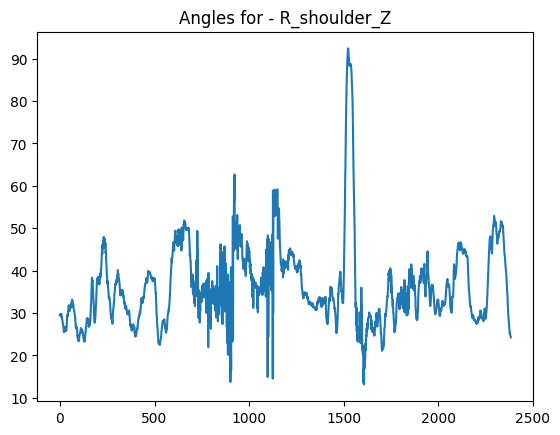

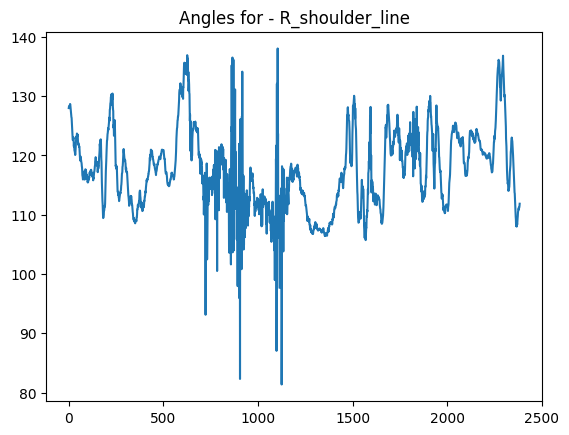

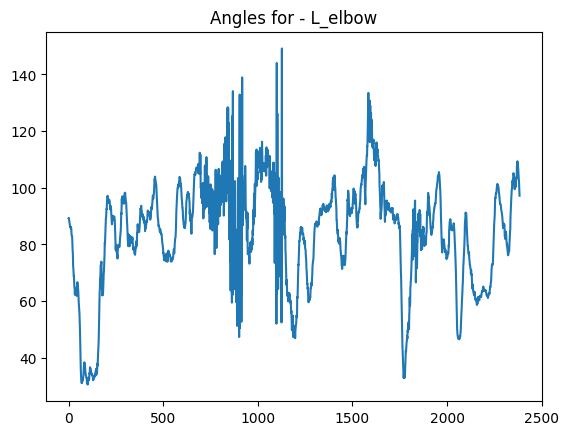

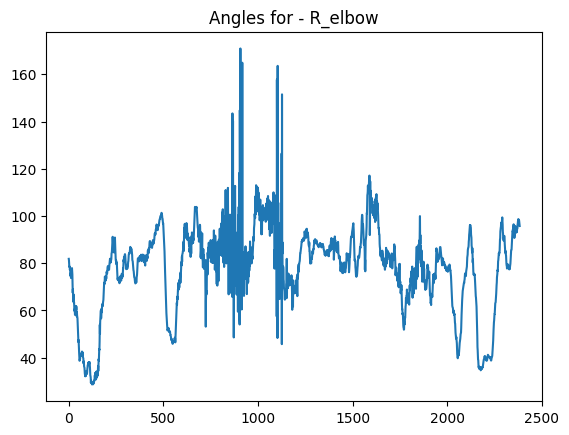

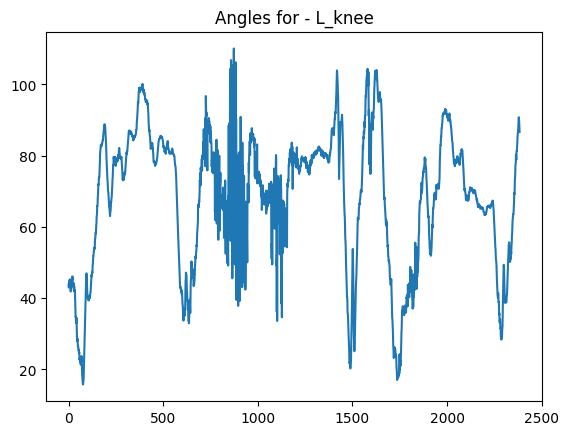

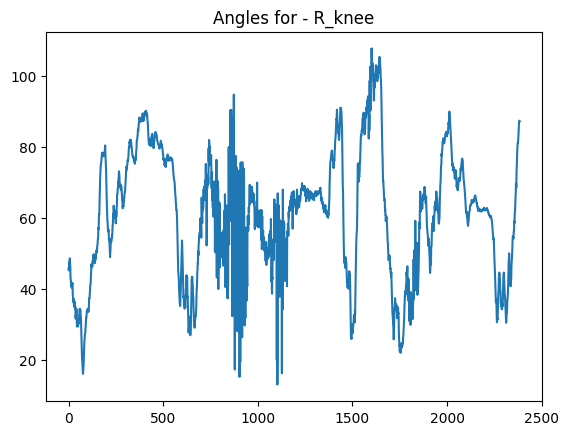

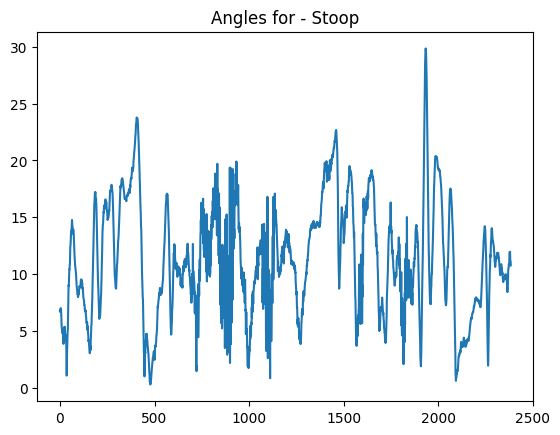

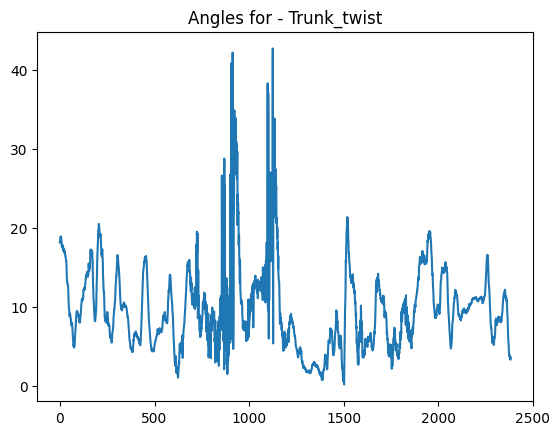

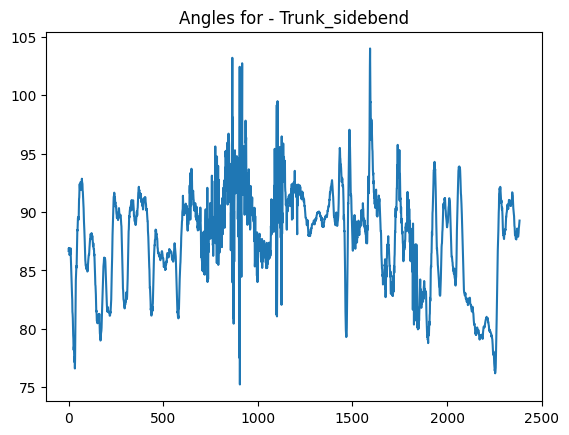

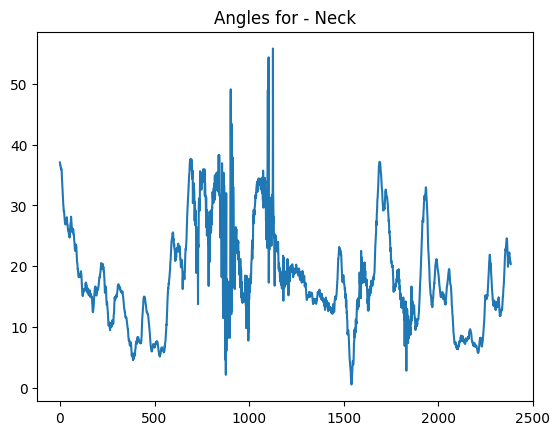

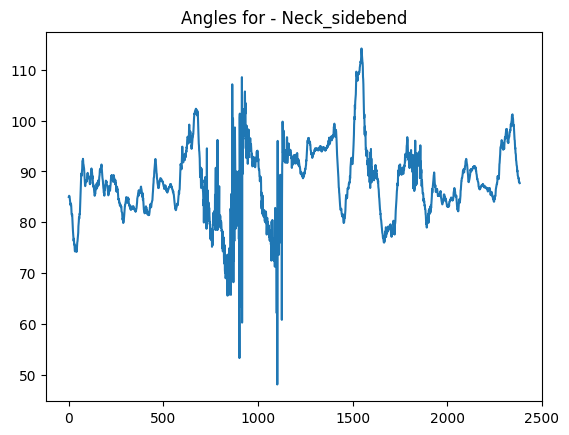

In [ ]:
for i in range(len(angles[0])-1):
    rula_eval.plot_angles(angles, i)